[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-recurrent-neural-nets/blob/main/assignments/assignment_01.ipynb)

We will be creating a simple character-level Recurrent Neural Network (RNN) to classify city names into their respective countries.

This character-level RNN will read a city name as a sequence of characters. We will use the data from [simplemap.com](https://simplemaps.com/data/world-cities). The data is preprocessed by extracting the some number of top countries and randomly sampling their respective cities. Then, the data is splitted into a train dataset and test dataset.  

# Data


In [2]:
import pandas as pd
import numpy as np
import json

root = "https://raw.githubusercontent.com/sk-classroom/asc-recurrent-neural-nets/main"

train_data = pd.read_csv(f"{root}/data/train.csv")
train_data.head()

,city,country
0,Shinhidaka,Japan
1,Gormi,India
2,Alleroy,Russia
3,Yelizovo,Russia
4,Sodegaura,Japan


In [3]:
train_input_data = train_data["city"].values
train_target_data = train_data["country"].values

Next, we will load a list of unique characters in the city names. 


In [4]:
# load unique charss from unique_chars.json
with open("../data/unique_chars.json", "r") as f:
    unique_chars = json.load(f)
print(unique_chars[:30])

[' ', ' ', "'", '(', ')', '-', '.', '/', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']


# Convert the city names into Pytorch Tensors 

We will prepare some utility functions to convert the city names into PyTorch Tensors by using one-hot encoding. Our one-hot vector has a length of the number of unique characters, with a 1 at the index of the current character and 0 everywhere else.


In [5]:
import torch

n_letters = len(unique_chars)


# Function to find the index of a letter without predefining all_letters
def letterToIndex(letter):
    return unique_chars.index(letter)


# Function to convert a string into a Tensor of shape <line_length x 1 x n_letters>
# Each character in the string is represented as a one-hot vector
def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor


# Demonstration of converting a letter and a string into Tensors
print(lineToTensor("B"))

# Demonstration of converting a city name into a sequence of Tensors
print(lineToTensor("Binghamton"))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Next, we will convert the country names into PyTorch Tensors. We will assign a unique integer to each country. 


In [6]:
unique_countries = np.unique(train_target_data)
country_to_index = {country: i for i, country in enumerate(unique_countries)}
train_target = train_data["country"].apply(lambda x: country_to_index[x]).values

# Or alternatively
# train_target = np.unonique(train_data["country"], return_inverse=True)[1]

train_target_data_tensor = torch.tensor(train_target)
train_target_data_tensor

tensor([ 7,  5, 11,  ...,  5,  9,  8])

# Create a Dataset and Data loader

We will create a custom dataset that takes the city names and the country names as input and returns the city names and the country names as an integer tensor.

Then, we will create a data loader with a batch size of 512. 


In [7]:
# TODO: Create a custom dataset class using torch.utils.data.Dataset
class CityCountryDataset(torch.utils.data.Dataset):
    def __init__(self, cities, countries):
        self.cities = cities
        self.countries = countries

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.cities)

    def __getitem__(self, idx):
        """Return the sample with the given index idx"""
        return self.cities[idx], self.countries[idx]


train_dataset = CityCountryDataset(train_input_data, train_target_data_tensor)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, shuffle=True, drop_last=True
    )

# Define the RNNs

Let's create a simple RNN with two linear layers.
* The input and hidden states will be concatenated first. 
* One layer computes the next hidden state, and another layer computes the output. 
* Tanh function is applied to the hidden state.  
* No non-linear activation function is applied to the output.


In [8]:
# TODO: Implement the RNN class
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        """Initialize the RNN with the given input, hidden, and output size"""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lin_i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        self.lin_i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = torch.nn.Tanh()

    def forward(self, input, hidden):
        """Forward pass of the RNN"""
        combined = torch.cat((input, hidden))
        output = self.lin_i2o(combined)
        hidden = self.lin_i2h(combined)
        hidden = self.tanh(hidden)
        return output, hidden

    def initHidden(self):
        """Return a tensor of shape <1 x hidden_size> filled with zeros"""
        return torch.zeros(self.hidden_size)


# TODO: Define the RNN model with hidden size 128
rnn = RNN(n_letters, 64, len(unique_countries))

Given a city name, we need to run the RNN on each character of the city name. Then, we will take the output of the RNN for the last character as the final output.  

Let's prepare a utility function to predict the country from the city name. 


In [9]:
# TODO: Run the RNN on the city name
def run_rnn(city_name, rnn):
    """Run the RNN on the given city name

    input:
    city_name: str
    rnn: RNN

    output:
    output: Tensor of shape <1 x n_countries>
    """

    # HINT: Initialize the hidden state
    hidden = rnn.initHidden()
 
    # HINT Convert the city name into a Tensor
    city_name_tensor = lineToTensor(city_name)

    # HINT Run the RNN on the input tensor
    for char_tensor in city_name_tensor:
        output, hidden = rnn(char_tensor, hidden)

    return output

# Let's train!

## Preparation for the training


We will use the `CrossEntropyLoss` as the loss function. This loss function is useful to train a model for multiclass classification. ([link](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


In [10]:
criterion = torch.nn.CrossEntropyLoss()

Optimizer


In [11]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=5e-3)

## Train


In [13]:
from tqdm import tqdm

n_epochs = 2  # number of epochs
loss_values = []  # to store the loss values at each step

# Set the model to training mode
rnn.train()

# Train the model
for epoch in range(n_epochs):

    pbar = tqdm(train_dataloader)

    for city_name_batch, country_index_batch in pbar:
        optimizer.zero_grad()
        loss = 0

        for name, target in zip(city_name_batch, country_index_batch):

            output = run_rnn(name, rnn)
            loss += criterion(output, target)

        loss.backward()
        optimizer.step()

        average_loss = loss.item() / len(city_name_batch)
        loss_values.append(average_loss)

        pbar.set_postfix({"loss": average_loss})

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:20<00:00,  1.52it/s, loss=1.73]


Text(0, 0.5, 'Loss')

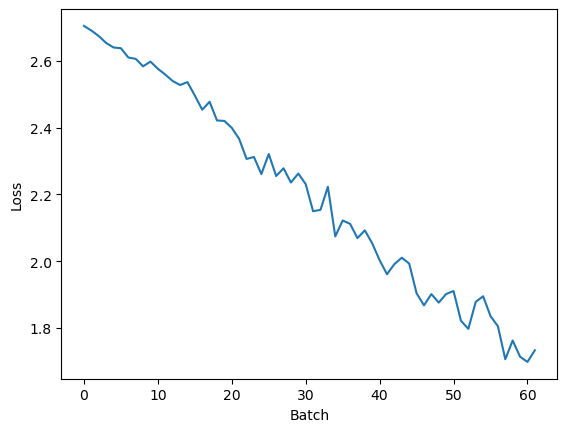

In [14]:
# Plot the loss values
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Batch")
plt.ylabel("Loss")

In [15]:
def predict_country(city_name, rnn):
    output = run_rnn(city_name, rnn)
    country_index = torch.argmax(output)
    return unique_countries[country_index]


city_name = "New York"
predict_country(city_name, rnn)

'United States'

The prediction won't be perfect because the model is trained on a small dataset. However, the model should be better than random. Let's check.  


In [16]:
# Read the test data
test_data = pd.read_csv(f"../data/test.csv")
test_data.head()

# Make predictions
predictions = [
    predict_country(city_name, rnn) for city_name in test_data["city"].values
]

# Compute the accuracy of the model
accuracy = (predictions == test_data["country"]).mean()

# Compute the accuracy of the random model
random_accuracy = 1 / len(unique_countries)

print(f"Accuracy: {accuracy:.2f}")
print(f"Random accuracy: {random_accuracy:.2f}")

Accuracy: 0.44
Random accuracy: 0.07


# Submit the results 

Please **git commit & push** the following two files created in the following cell. 

1. "~/assignments/rnn_test_predictions.csv" 

2. "~/assignments/rnn_loss_values.csv"


In [17]:
pd.DataFrame(predictions).to_csv("./rnn_test_predictions.csv", index=False)
pd.DataFrame(loss_values).to_csv("./rnn_loss_values.csv", index=False)